In [7]:
from Generator import generate_synthetic_image
from Models import KeypointDataset

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

Generating examples without homography:


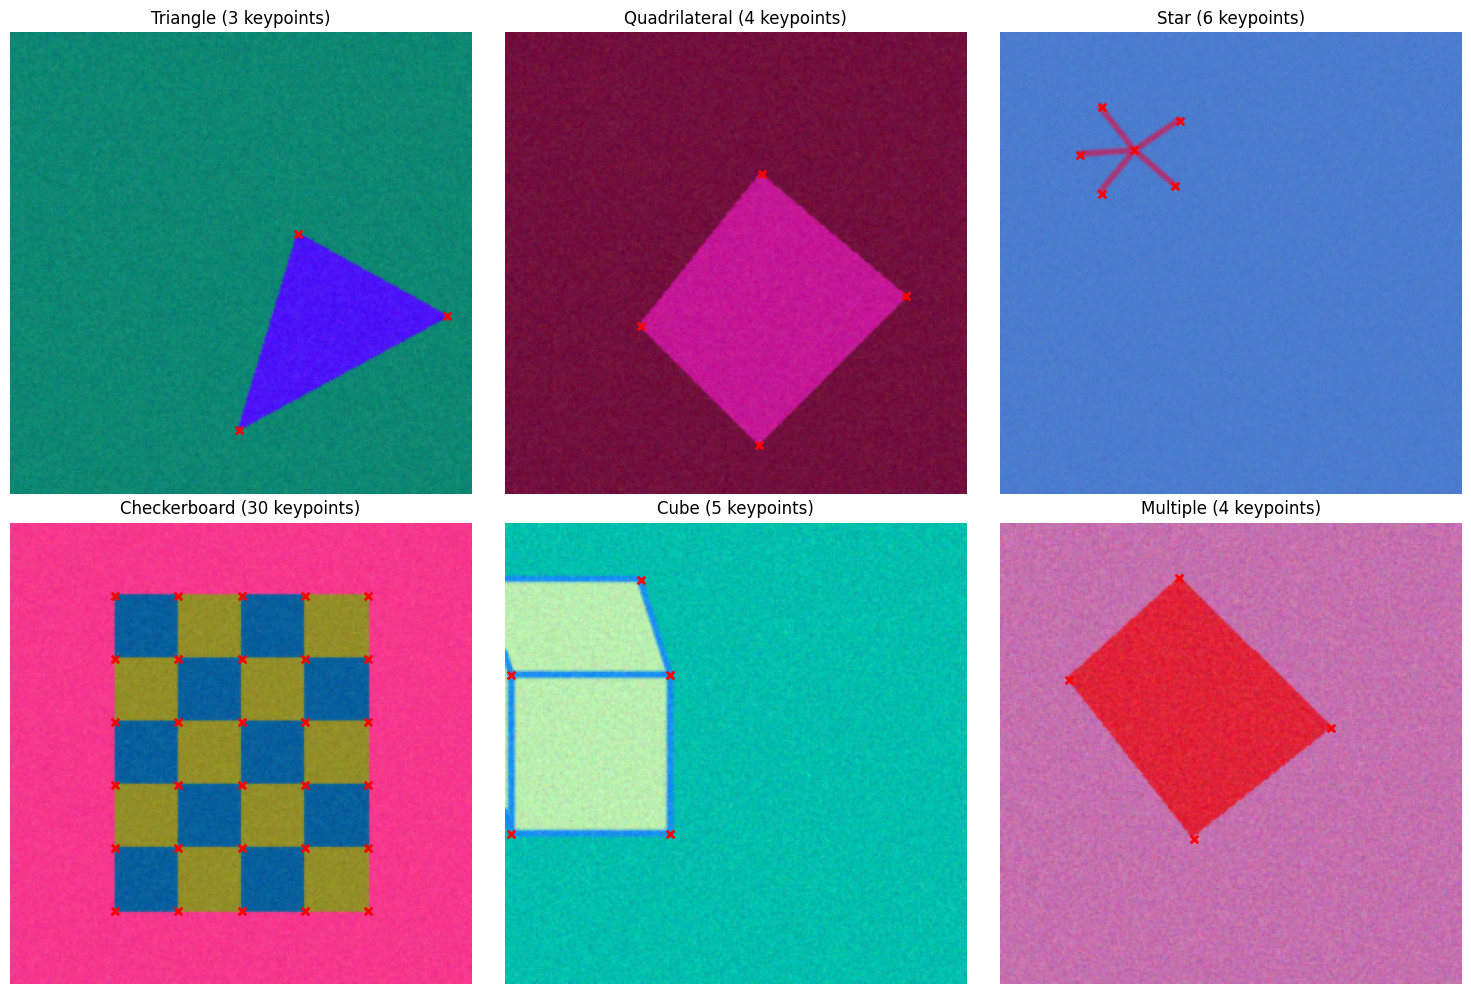

In [9]:
# Test and visualize

def visualize_sample(img, keypoints, title=""):
    """Visualize image with keypoints marked."""
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    if len(keypoints) > 0:
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=50, marker='x')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Generate examples of each type
shape_types = ["triangle", "quadrilateral", "star", "checkerboard", "cube", "multiple"]

print("Generating examples without homography:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, shape_type in enumerate(shape_types):
    img, keypoints = generate_synthetic_image(256, 256, shape_type=shape_type, use_homography=False)
    axes[i].imshow(img)
    axes[i].scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=30, marker='x', linewidths=2)
    axes[i].set_title(f"{shape_type.capitalize()} ({len(keypoints)} keypoints)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



Generating examples with homography:


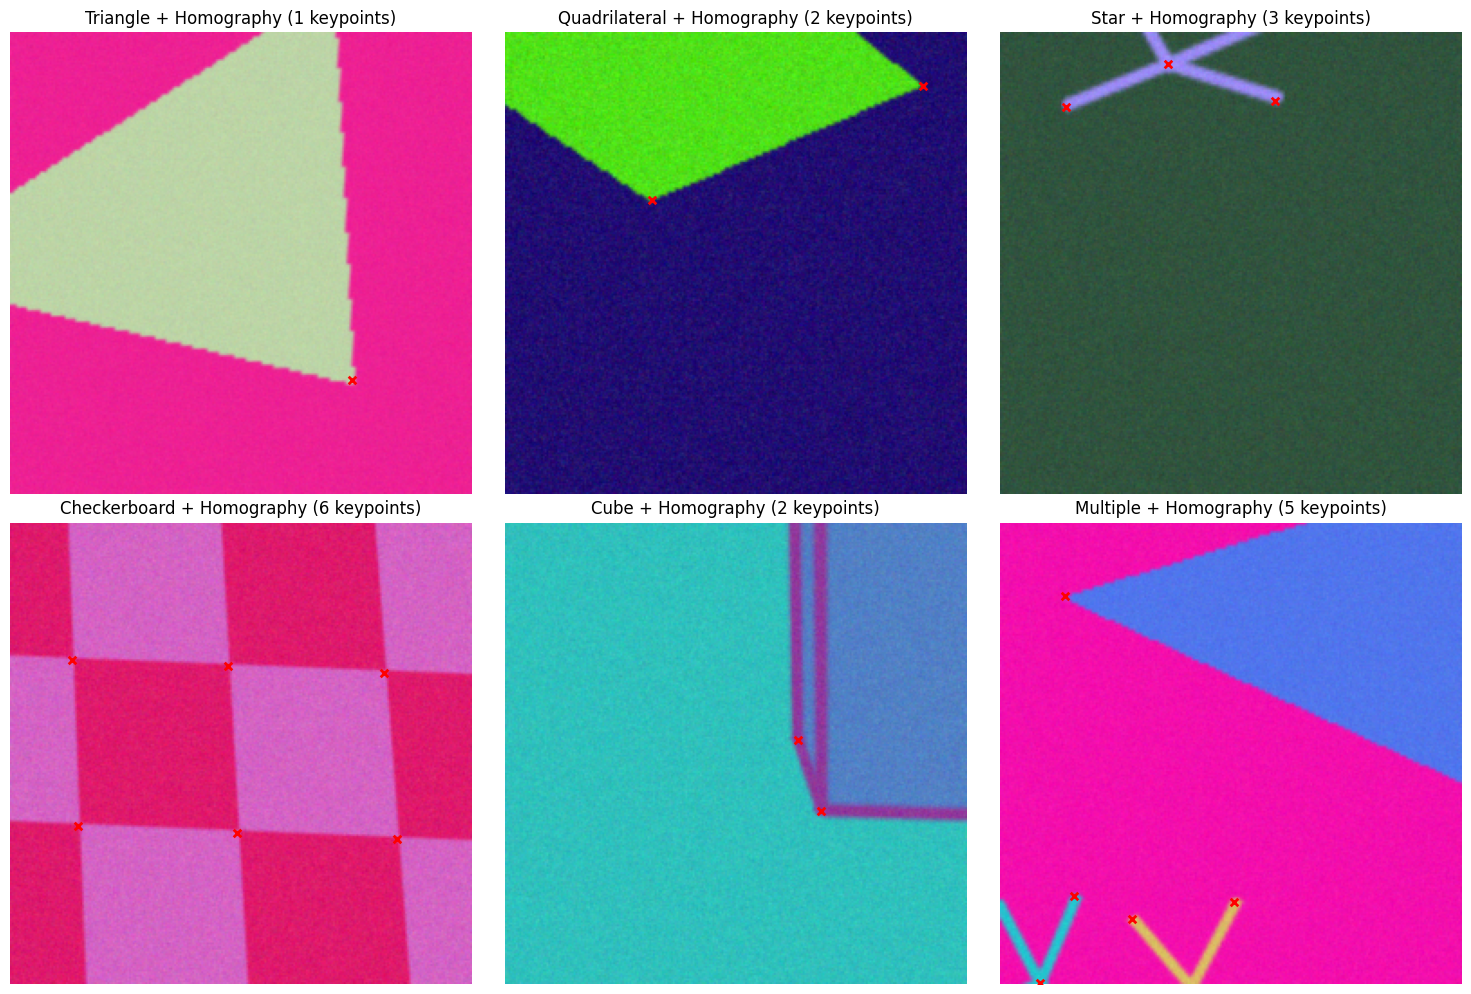

In [5]:
print("\nGenerating examples with homography:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, shape_type in enumerate(shape_types):
    img, keypoints = generate_synthetic_image(256, 256, shape_type=shape_type, use_homography=True)
    axes[i].imshow(img)
    axes[i].scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=30, marker='x', linewidths=2)
    axes[i].set_title(f"{shape_type.capitalize()} + Homography ({len(keypoints)} keypoints)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
#  # ============================================================
# # DATASET DEMO
# # ============================================================
# """
# This section demonstrates the KeypointDataset class which provides:
#
# 1. Two generation modes:
#    - On-the-fly: Generates images during training (slower but unlimited variety)
#    - Pre-generated: Generates all samples upfront (faster training, uses more memory)
#
# 2. Data augmentation: Random flips, brightness, and contrast adjustments
#
# 3. Automatic preprocessing:
#    - RGB to grayscale conversion
#    - Normalization to [0, 1]
#    - Training target preparation in (65, H/8, W/8) format
#
# The dataset integrates seamlessly with PyTorch DataLoader for batching.
# """
#
# # Create dataset WITHOUT pre-generation (generates on-the-fly)
# print("Creating dataset with on-the-fly generation...")
# dataset_onthefly = KeypointDataset(
#     num_samples=50,
#     image_shape=(256, 256),
#     generate_fn=generate_synthetic_image,
#     generate_kwargs={
#         'width': 256,
#         'height': 256,
#         'shape_type': 'random',
#         'use_homography': False
#     },
#     augment=False,
#     pregenerate=False  # Generate on-the-fly
# )
#
# print(f"✓ Dataset created with {len(dataset_onthefly)} samples (on-the-fly generation)")
# print()
#
# # Create dataset WITH pre-generation (faster for training)
# print("Creating dataset with pre-generation...")
# dataset_pregenerated = KeypointDataset(
#     num_samples=200,
#     image_shape=(256, 256),
#     generate_fn=generate_synthetic_image,
#     generate_kwargs={
#         'width': 256,
#         'height': 256,
#         'shape_type': 'random',
#         'use_homography': True
#     },
#     augment=False,
#     pregenerate=True  # Pre-generate all samples
# )
#
# print()
# print(f"✓ Dataset created with {len(dataset_pregenerated)} samples (pre-generated)")


In [5]:
# Helper function to extract keypoint positions from target tensor
def extract_keypoints_from_target(target_tensor):
    """
    Extract keypoint positions from target tensor.

    Args:
        target_tensor: (65, H/8, W/8) target tensor

    Returns:
        keypoint_positions: List of [x, y] positions in image coordinates
    """
    target_np = target_tensor.numpy() if hasattr(target_tensor, 'numpy') else target_tensor

    Hc, Wc = target_np.shape[1], target_np.shape[2]  # Downsampled dimensions (32, 32)
    keypoint_positions = []

    for h in range(Hc):
        for w in range(Wc):
            # Check if any of the 64 spatial channels are active (not the "no point" channel)
            cell_data = target_np[:64, h, w]
            if cell_data.sum() > 0:
                # Find which position in the 8x8 cell is active
                active_idx = np.argmax(cell_data)
                # Convert to image coordinates
                sub_y = active_idx // 8
                sub_x = active_idx % 8
                y = h * 8 + sub_y
                x = w * 8 + sub_x
                keypoint_positions.append([x, y])

    return np.array(keypoint_positions) if len(keypoint_positions) > 0 else np.array([]).reshape(0, 2)



In [6]:
# # Visualize samples from dataset WITHOUT pre-generation
#
# print("Samples from on-the-fly generation dataset (no homography):")
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()
#
# for i in range(6):
#     # Get sample from dataset
#     img_tensor, target_tensor = dataset_onthefly[i]
#
#     # Convert tensor back to numpy for visualization
#     img_np = (img_tensor[0].numpy() * 255).astype(np.uint8)
#
#     # Extract keypoint locations from target
#     keypoint_positions = extract_keypoints_from_target(target_tensor)
#
#     # Plot image
#     axes[i].imshow(img_np, cmap='gray')
#
#     # Overlay keypoints
#     if len(keypoint_positions) > 0:
#         axes[i].scatter(keypoint_positions[:, 0], keypoint_positions[:, 1],
#                         c='red', s=50, marker='x', linewidths=2)
#
#     axes[i].set_title(f'Sample {i + 1} ({len(keypoint_positions)} keypoints)')
#     axes[i].axis('off')
#
# plt.tight_layout()
# plt.show()


In [7]:
# # Visualize samples from dataset WITH pre-generation
#
# print("Samples from pre-generated dataset (with homography):")
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()
#
# for i in range(6):
#     # Get sample from dataset
#     img_tensor, target_tensor = dataset_pregenerated[i]
#
#     # Convert tensor back to numpy for visualization
#     img_np = (img_tensor[0].numpy() * 255).astype(np.uint8)
#
#     # Extract keypoint locations from target
#     keypoint_positions = extract_keypoints_from_target(target_tensor)
#
#     # Plot image
#     axes[i].imshow(img_np, cmap='gray')
#
#     # Overlay keypoints
#     if len(keypoint_positions) > 0:
#         axes[i].scatter(keypoint_positions[:, 0], keypoint_positions[:, 1],
#                         c='red', s=50, marker='x', linewidths=2)
#
#     axes[i].set_title(f'Sample {i + 1} ({len(keypoint_positions)} keypoints)')
#     axes[i].axis('off')
#
# plt.tight_layout()
# plt.show()


In [8]:
# # Test DataLoader with batch
#
# print("Testing DataLoader with batching...")
# train_loader = DataLoader(
#     dataset_pregenerated,
#     batch_size=8,
#     shuffle=True,
#     num_workers=0  # Use 0 for Windows compatibility
# )
#
# # Get one batch
# for batch_images, batch_targets in train_loader:
#     print(f"Batch images shape: {batch_images.shape}")  # Should be (8, 1, 256, 256)
#     print(f"Batch targets shape: {batch_targets.shape}")  # Should be (8, 65, 32, 32)
#
#     # Visualize the batch with keypoints overlaid
#     fig, axes = plt.subplots(2, 4, figsize=(16, 8))
#     axes = axes.ravel()
#
#     for i in range(8):
#         # Get image
#         img = (batch_images[i, 0].numpy() * 255).astype(np.uint8)
#
#         # Extract keypoint locations from target
#         keypoint_positions = extract_keypoints_from_target(batch_targets[i])
#
#         # Plot image
#         axes[i].imshow(img, cmap='gray')
#
#         # Overlay keypoints
#         if len(keypoint_positions) > 0:
#             axes[i].scatter(keypoint_positions[:, 0], keypoint_positions[:, 1],
#                             c='red', s=50, marker='x', linewidths=2)
#
#         axes[i].set_title(f'Batch {i + 1} ({len(keypoint_positions)} kpts)')
#         axes[i].axis('off')
#
#     plt.tight_layout()
#     plt.show()
#
#     break  # Only show first batch
#
# print("✓ DataLoader test complete!")
